#%%[markdown]

 ## Generative Recurrent Neural Networks in weight space

In [ ]:
#%%

# %load_ext autoreload
# %autoreload 2

from utils import *
from loaders import *
from models import *

import jax
print("\n+=+=+=+=+ Training Weight Space Model +=+=+=+=+")
print("Available devices:", jax.devices())

from jax import config
# config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)
# config.update("jax_enable_x64", True)
# from jax.experimental import checkify

import numpy as np
import jax.numpy as jnp
import equinox as eqx
import torch
import optax

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_theme(context='poster', 
             style='ticks',
             font='sans-serif', 
             font_scale=1, 
             color_codes=True, 
             rc={"lines.linewidth": 1})
mpl.rcParams['savefig.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['savefig.bbox'] = 'tight'

import yaml
import argparse
import os
import time
from pprint import pprint
import sys
import pickle

import warnings
warnings.filterwarnings("ignore")


+=+=+=+=+ Training Weight Space Model +=+=+=+=+
Available devices: [CudaDevice(id=0)]


In [ ]:
#%%

try:
    __IPYTHON__
    _in_ipython_session = True
except NameError:
    _in_ipython_session = False

if _in_ipython_session:
    args = argparse.Namespace(config_file='config.yaml')
    print("Notebook session: Using default config.yaml file")
else:
    if len(sys.argv) == 1:
        # Use default config.yaml file
        args = argparse.Namespace(config_file='config.yaml')
        print("No config file provided: Using default config.yaml file")
    elif len(sys.argv) > 1:
        # Use command line argument as config file
        args = argparse.Namespace(config_file=sys.argv[1])
        print(f"Using command line {sys.argv[1]} as config file")
    else:
        print("Usage: python main.py <config_file>")
        sys.exit(1)

with open(args.config_file, 'r') as file:
    config = yaml.safe_load(file)

seed = config['general']['seed']
main_key = jax.random.PRNGKey(seed)
np.random.seed(seed)
torch.manual_seed(seed)

Notebook session: Using default config.yaml file


In [ ]:
#%%

train = config['general']['train']
data_path = config['general']['data_path']
save_path = config['general']['save_path']

### Create and setup the run and data folders
if train:
    if save_path is not None:
        run_folder = save_path
    else:
        run_folder = make_run_folder('./runs/')
    data_folder = data_path
else:
    run_folder = "./"
    data_folder = f"../../{data_path}"

print("Using run folder:", run_folder)
logger, checkpoints_folder, plots_folder, artefacts_folder = setup_run_folder(run_folder, training=train)

## Print the config file using the logger and pprint
logger.info(f"Config file: {args.config_file}")
logger.info("==== Config file's contents ====")
# pprint(config)

## Log the config using the logger
for key, value in config.items():
    if isinstance(value, dict):
        logger.info(f"{key}:")
        for sub_key, sub_value in value.items():
            logger.info(f"  {sub_key}: {sub_value}")
    else:
        logger.info(f"{key}: {value}")

Using run folder: ./
2025-04-21 09:45:33,866 - INFO - Started logging to ./artefacts/testing.log
2025-04-21 09:45:33,866 - INFO - Config file: config.yaml
2025-04-21 09:45:33,867 - INFO - ==== Config file's contents ====
2025-04-21 09:45:33,867 - INFO - general:
2025-04-21 09:45:33,867 - INFO -   seed: 2024
2025-04-21 09:45:33,867 - INFO -   train: False
2025-04-21 09:45:33,868 - INFO -   dataset: lotka
2025-04-21 09:45:33,868 - INFO -   data_path: ./data/dynamics/lotka/
2025-04-21 09:45:33,868 - INFO -   save_path: None
2025-04-21 09:45:33,868 - INFO - data:
2025-04-21 09:45:33,868 - INFO -   downsample_factor: 1
2025-04-21 09:45:33,869 - INFO -   resolution: [32, 32]
2025-04-21 09:45:33,869 - INFO -   traj_length: 1000
2025-04-21 09:45:33,869 - INFO - model:
2025-04-21 09:45:33,869 - INFO -   mlp_width_size: 48
2025-04-21 09:45:33,869 - INFO -   mlp_depth: 3
2025-04-21 09:45:33,870 - INFO -   activation: swish
2025-04-21 09:45:33,870 - INFO -   input_prev_data: False
2025-04-21 09:45

cp: 'main.py' and './main.py' are the same file
cp: 'utils.py' and './utils.py' are the same file
cp: 'loaders.py' and './loaders.py' are the same file
cp: 'models.py' and './models.py' are the same file
cp: 'config.yaml' and './config.yaml' are the same file


 #### Dynamics-Repeat Dataset ####
Training sequence length: 256
2025-04-21 09:45:34,391 - INFO - Input sequence shape: (1024, 256, 2)
2025-04-21 09:45:34,392 - INFO - Labels/OutputSequence shape: (1024, 256, 2)
2025-04-21 09:45:34,392 - INFO - Seq length: 256
2025-04-21 09:45:34,392 - INFO - Data size: 2
2025-04-21 09:45:34,393 - INFO - Min/Max in the dataset: (-1.0, 1.378643503171046)
2025-04-21 09:45:34,393 - INFO - Number of batches:
2025-04-21 09:45:34,393 - INFO -   - Train: 15
2025-04-21 09:45:34,394 - INFO -   - Test: 3


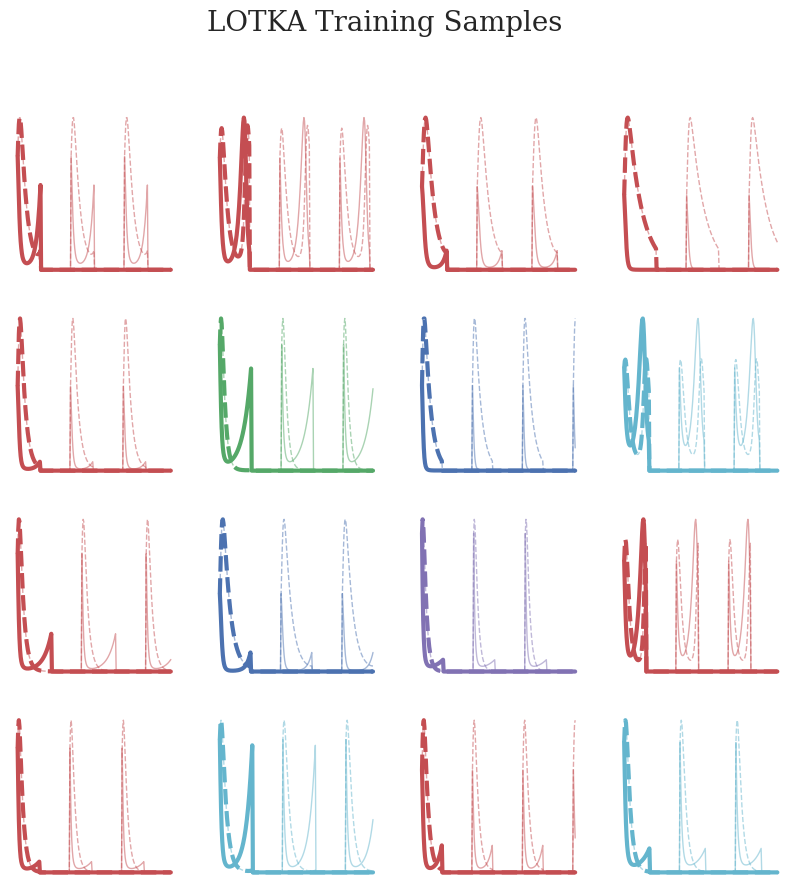

In [ ]:
#%%

trainloader, testloader, data_props = make_dataloaders(data_folder, config)
nb_classes, seq_length, data_size, width = data_props

batch = next(iter(testloader))
(in_sequence, times), output = batch
logger.info(f"Input sequence shape: {in_sequence.shape}")
logger.info(f"Labels/OutputSequence shape: {output.shape}")
logger.info(f"Seq length: {seq_length}")
logger.info(f"Data size: {data_size}")
logger.info(f"Min/Max in the dataset: {np.min(in_sequence), np.max(in_sequence)}")
logger.info("Number of batches:")
logger.info(f"  - Train: {trainloader.num_batches}")
logger.info(f"  - Test: {testloader.num_batches}")

## Plot a few samples in a 4x4 grid (chose them at random)
fig, axs = plt.subplots(4, 4, figsize=(10, 10), sharex=True)
colors = ['r', 'g', 'b', 'c', 'm', 'y']

dataset = config['general']['dataset']
image_datasets = ["mnist", "mnist_fashion", "cifar", "celeba"]
dynamics_datasets = ["lorentz63", "lorentz96", "lotka", "trends", "mass_spring_damper"]
repeat_datasets = ["lotka"]

res = (width, width, data_size)
dim0, dim1 = (0, 1)
for i in range(4):
    for j in range(4):
        idx = np.random.randint(0, in_sequence.shape[0])
        if dataset in image_datasets:
            to_plot = in_sequence[idx].reshape(res)
            if dataset=="celeba":
                to_plot = (to_plot + 1) / 2
            axs[i, j].imshow(to_plot, cmap='gray')
        elif dataset=="trends":
            axs[i, j].plot(in_sequence[idx], color=colors[output[idx]])
        elif dataset in repeat_datasets:
            # axs[i, j].plot(in_sequence[idx, :, dim0], in_sequence[idx, :, dim1], color=colors[(i*j)%len(colors)])
            # axs[i, j].plot(output[idx, :, dim0], output[idx, :, dim1], color=colors[(i*j)%len(colors)], linestyle='--')
            ## Make 4 plots against time steps instead
            axs[i, j].plot(output[idx, :, dim0], color=colors[(i*j)%len(colors)], linestyle='-', lw=1, alpha=0.5)
            axs[i, j].plot(output[idx, :, dim1], color=colors[(i*j)%len(colors)], linestyle='--', lw=1, alpha=0.5)
            axs[i, j].plot(in_sequence[idx, :, dim0], color=colors[(i*j)%len(colors)], lw=3)
            axs[i, j].plot(in_sequence[idx, :, dim1], color=colors[(i*j)%len(colors)], linestyle='--', lw=3)
        else:
            # axs[i, j].plot(in_sequence[idx, :, dim0], in_sequence[idx, :, dim1], color=colors[output[idx]%len(colors)])
            axs[i, j].plot(in_sequence[idx, :, dim0], color=colors[output[idx]%len(colors)], lw=3)
            axs[i, j].plot(in_sequence[idx, :, dim1], color=colors[output[idx]%len(colors)], linestyle='--', lw=3)

        if dataset not in repeat_datasets:
            axs[i, j].set_title(f"Class: {output[idx]}", fontsize=12)
        axs[i, j].axis('off')

plt.suptitle(f"{dataset.upper()} Training Samples", fontsize=20)
plt.draw();
plt.savefig(plots_folder+"samples_train.png", dpi=100, bbox_inches='tight')

In [ ]:
# %% Define the model and loss function

model_key, train_key = jax.random.split(main_key, num=2)
model = make_model(model_key, data_size, config)
untrained_model = model

nb_recons_loss_steps = config['training']['nb_recons_loss_steps']
use_nll_loss = config['training']['use_nll_loss']

def loss_fn(model, batch, key):
    """ Loss function for the model. A batch contains: (Xs, Ts), Ys
    Xs: (batch, time, data_size)
    Ts: (batch, time)
    Ys: (batch, num_classes)
    """
    (X_true, times), X_true_out = batch

    X_recons = model(X_true, times, key, inference_start=None)

    if nb_recons_loss_steps is not None:  ## Use all the steps
        ## Randomly sample some steps in the sequence for the loss
        batch_size, nb_timesteps = X_true.shape[0], X_true.shape[1]
        indices_0 = jnp.arange(batch_size)
        indices_1 = jax.random.randint(key, (batch_size, nb_recons_loss_steps), 0, nb_timesteps)

        X_recons_ = jnp.stack([X_recons[indices_0, indices_1[:,j]] for j in range(nb_recons_loss_steps)], axis=1)

        if dataset not in repeat_datasets:
            X_true_ = jnp.stack([X_true[indices_0, indices_1[:,j]] for j in range(nb_recons_loss_steps)], axis=1)
        else:
            X_true_ = jnp.stack([X_true_out[indices_0, indices_1[:,j]] for j in range(nb_recons_loss_steps)], axis=1)

    else:
        X_recons_ = X_recons
        if dataset not in repeat_datasets:
            X_true_ = X_true
        else:
            X_true_ = X_true_out

    if use_nll_loss:
        means = X_recons_[:, :, :data_size]
        stds = X_recons_[:, :, data_size:]
        loss_r = jnp.log(stds) + 0.5*((X_true_ - means)/stds)**2
    else:
        loss_r = optax.l2_loss(X_recons_, X_true_)

    loss = jnp.mean(loss_r)
    return loss, (loss,)


@eqx.filter_jit
def train_step(model, batch, opt_state, key):
    print('\nCompiling function "train_step" ...')

    (loss, aux_data), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model, batch, key)

    updates, opt_state = opt.update(grads, opt_state, model, value=loss)        ## For reduce on plateau loss accumulation
    model = eqx.apply_updates(model, updates)

    return model, opt_state, loss, aux_data

Number of learnable parameters in the root network: 4.9 k
Number of learnable parameters for the seqtoseq's transition: 24000.2 k
Number of learnable parameters in the model: 24005.1 k


In [ ]:
#%% Train the model

if train:

    opt = optax.chain(
        optax.clip(config['optimizer']['gradients_lim']),
        optax.adabelief(config['optimizer']['init_lr']),
        optax.contrib.reduce_on_plateau(
            patience= config['optimizer']['on_plateau']['patience'],
            cooldown=config['optimizer']['on_plateau']['cooldown'],
            factor=config['optimizer']['on_plateau']['factor'],
            rtol=config['optimizer']['on_plateau']['rtol'],
            accumulation_size=config['optimizer']['on_plateau']['accum_size'],
            min_scale=config['optimizer']['on_plateau']['min_scale'],
        ),
    )
    opt_state = opt.init(eqx.filter(model, eqx.is_array))

    ## If a mode file exists, load it and use it
    if os.path.exists(artefacts_folder+"model.eqx"):
        model = eqx.tree_deserialise_leaves(artefacts_folder+"model.eqx", model)
        logger.info("Model found in run folder. Finetuning from these.")
        try:
            with open(artefacts_folder+"opt_state.pkl", 'rb') as f:
                opt_state = pickle.load(f)
        except:
            logger.info("No optimizer state for finetuning. Starting from scratch.")
    else:
        logger.info("No model found in run folder. Training from scratch.")

    losses = []
    med_losses_per_epoch = []
    lr_scales = []

    print_every = config['training']['print_every']
    checkpoint_every = config['training']['checkpoint_every']

    nb_epochs = config['training']['nb_epochs']
    logger.info(f"\n\n=== Beginning training ... ===")
    logger.info(f"  - Number of epochs: {nb_epochs}")
    logger.info(f"  - Number of batches: {trainloader.num_batches}")
    logger.info(f"  - Total number of GD steps: {trainloader.num_batches*nb_epochs}")

    start_time = time.time()

    for epoch in range(nb_epochs):

        losses_epoch = []

        for i, batch in enumerate(trainloader):
            train_key, _ = jax.random.split(train_key)
            model, opt_state, loss, aux = train_step(model, batch, opt_state, train_key)

            losses_epoch.append(loss)
            losses.append(loss)

            lr_scales.append(optax.tree_utils.tree_get(opt_state, "scale"))

        mean_epoch, median_epoch = np.mean(losses_epoch), np.median(losses_epoch)

        if epoch%print_every==0 or epoch<=3 or epoch==nb_epochs-1:
            logger.info(
                f"Epoch {epoch:-4d}/{nb_epochs:-4d}     Train Loss   -Mean: {mean_epoch:.6f},   -Median: {median_epoch:.6f},   -Latest: {loss:.6f}"
            )

        if epoch%checkpoint_every==0 or epoch==nb_epochs-1:
            eqx.tree_serialise_leaves(checkpoints_folder+f"model_{epoch}.eqx", model)
            np.save(artefacts_folder+"losses.npy", np.array(losses))
            np.save(artefacts_folder+"lr_scales.npy", np.array(lr_scales))

            ## Only save the best model with the lowest mean loss
            med_losses_per_epoch.append(median_epoch)
            if epoch==0 or median_epoch<=np.min(med_losses_per_epoch[:-1]):
                eqx.tree_serialise_leaves(artefacts_folder+"model.eqx", model)
                with open(artefacts_folder+"opt_state.pkl", 'wb') as f:
                    pickle.dump(opt_state, f)
                logger.info("Best model saved ...")

        if epoch==3:     ## Print the output of nvidia-smi to check VRAM usage
            os.system("nvidia-smi")

    wall_time = time.time() - start_time
    logger.info("\nTraining complete. Total time: %d hours %d mins %d secs" %seconds_to_hours(wall_time))

else:
    model = eqx.tree_deserialise_leaves(artefacts_folder+"model.eqx", model)

    try:
        losses = np.load(artefacts_folder+"losses.npy")
        lr_scales = np.load(artefacts_folder+"lr_scales.npy")
    except:
        losses = []

    logger.info(f"Model loaded from {run_folder}model.eqx")

2025-04-21 09:45:35,870 - INFO - Model loaded from ./model.eqx


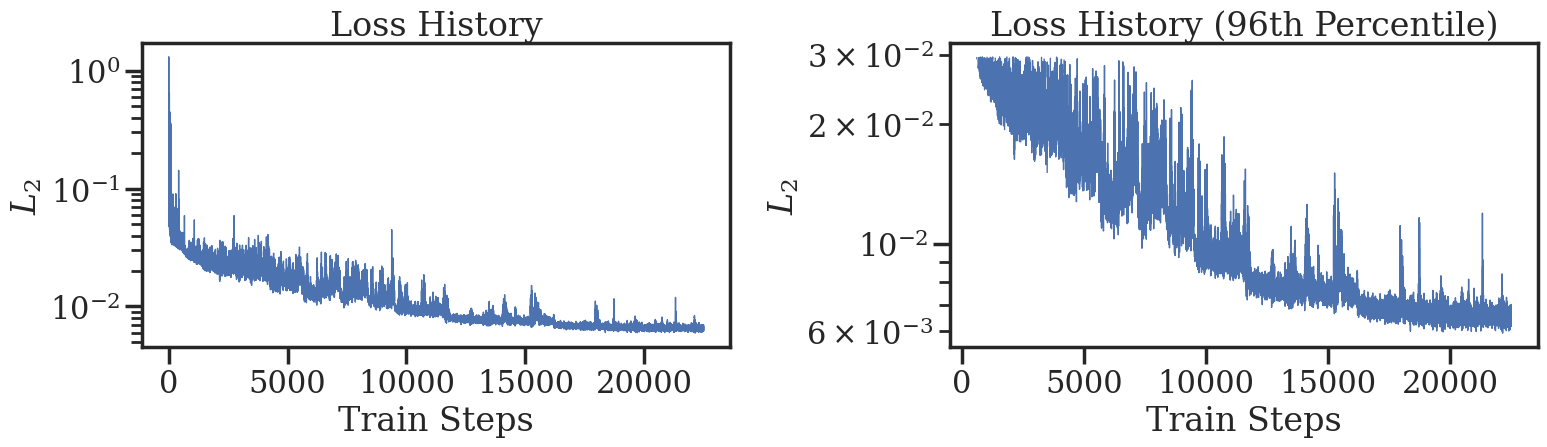

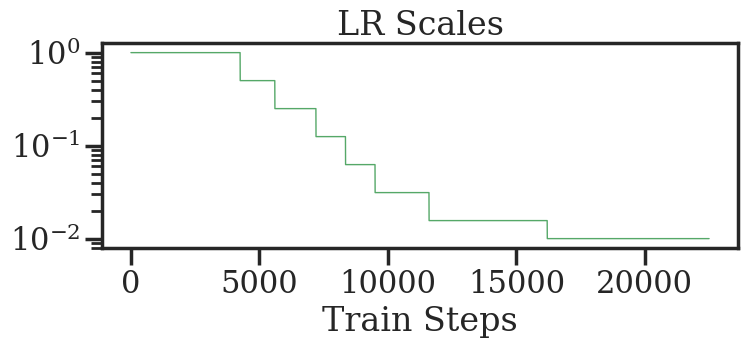

In [ ]:
# %% Visualise the training losses

if not os.path.exists(artefacts_folder+"losses.npy"):
    try:
        with open(artefacts_folder+"training.log", 'r') as f:
            lines = f.readlines()
        losses = []
        search_term = "Train Loss (Mean)"
        for line in lines:
            if search_term in line:
                loss = float(line.split(f"{search_term}: ")[1].strip())
                losses.append(loss)
        logger.info("Losses found in the training.log file")
    except:
        logger.info("No losses found in the training.log file")


fig, (ax, ax2) = plt.subplots(1, 2, figsize=(16, 5))

clean_losses = np.array(losses)
epochs = np.arange(len(losses))
loss_name = "NLL" if use_nll_loss else r"$L_2$"
ax = sbplot(epochs, clean_losses, title="Loss History", x_label='Train Steps', y_label=loss_name, ax=ax, y_scale="linear" if use_nll_loss else "log");

clean_losses = np.where(clean_losses<np.percentile(clean_losses, 96), clean_losses, np.nan)
## Plot a second plot with the outliers removed
ax2 = sbplot(epochs, clean_losses, title="Loss History (96th Percentile)", x_label='Train Steps', y_label=loss_name, ax=ax2, y_scale="linear" if use_nll_loss else "log");

plt.draw();
plt.savefig(plots_folder+"loss.png", dpi=100, bbox_inches='tight')

if os.path.exists(artefacts_folder+"lr_scales.npy"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    ax = sbplot(lr_scales, "g-", title="LR Scales", x_label='Train Steps', ax=ax, y_scale="log");

    # plt.legend()
    plt.draw();
    plt.savefig(plots_folder+"lr_scales.png", dpi=100, bbox_inches='tight')

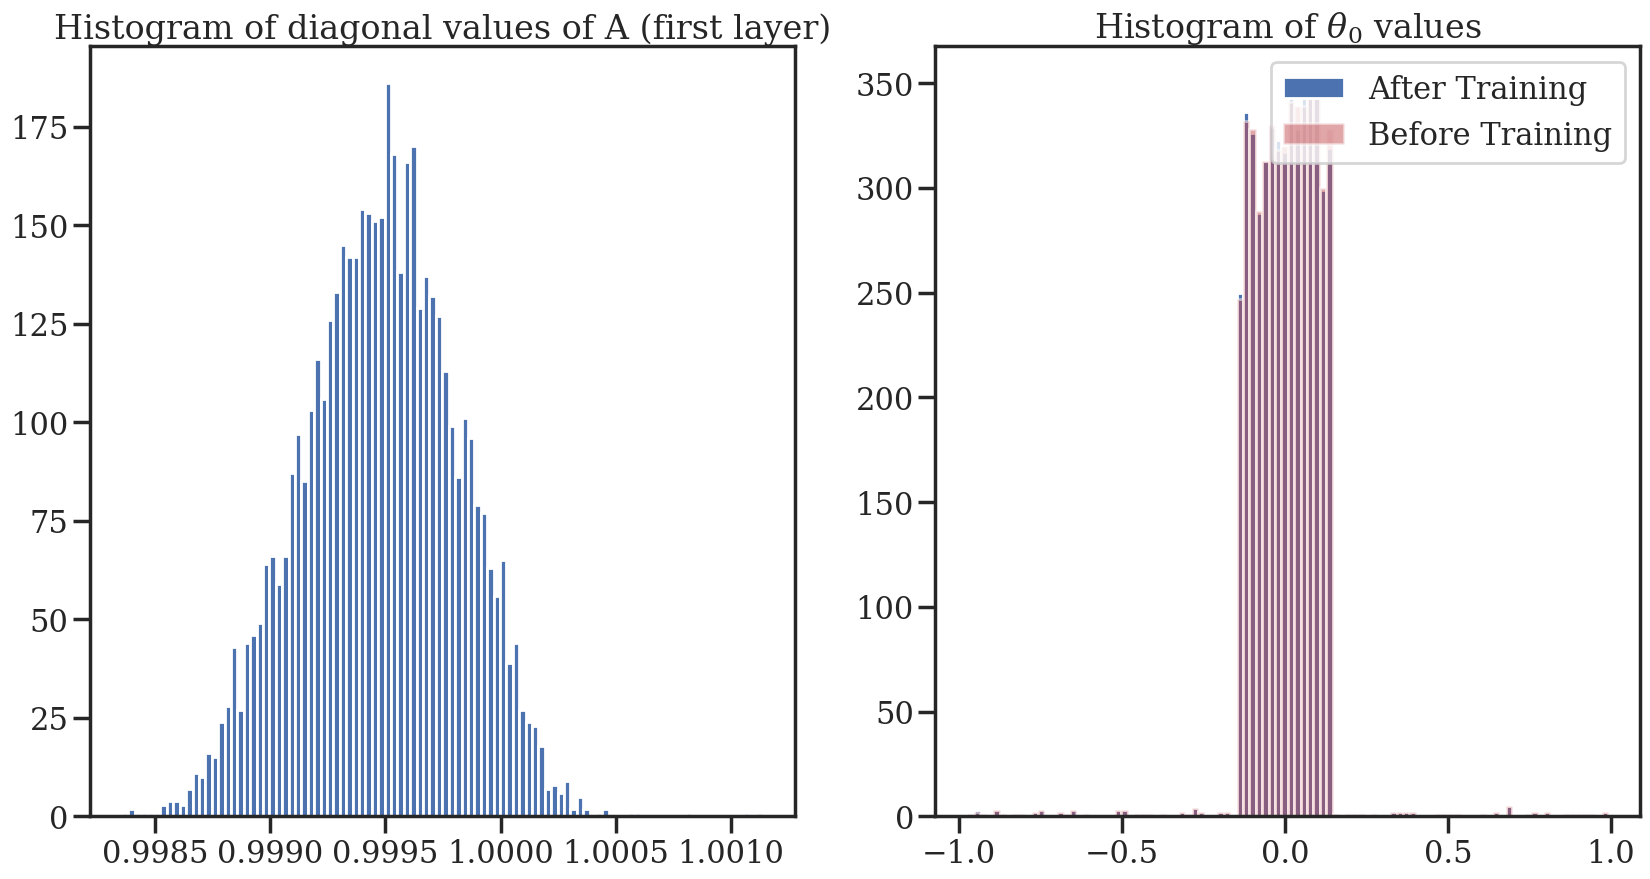

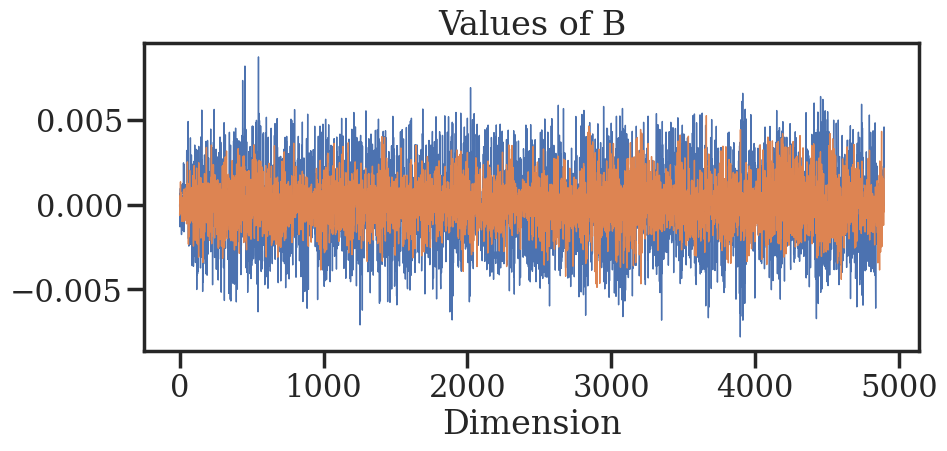

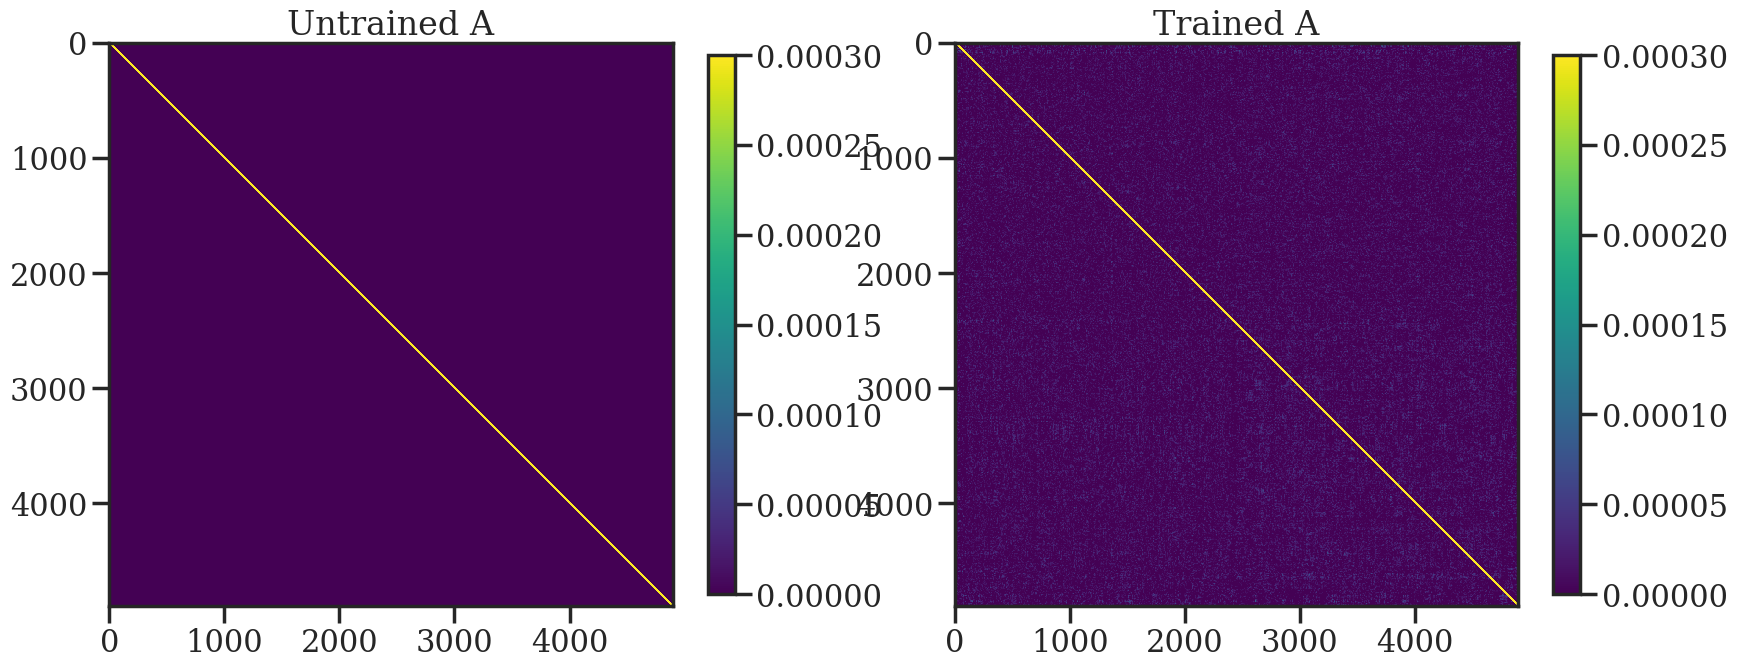

In [ ]:
# %% Other visualisation of the model

## Let's visualise the distribution of values along the main diagonal of A and theta
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].hist(jnp.diag(model.As[0], k=0), bins=100)

axs[0].set_title("Histogram of diagonal values of A (first layer)")

axs[1].hist(model.thetas[0], bins=100, label="After Training")
axs[1].hist(untrained_model.thetas[0], bins=100, alpha=0.5, label="Before Training", color='r')
axs[1].set_title(r"Histogram of $\theta_0$ values")
plt.legend();
plt.draw();
plt.savefig(plots_folder+"A_theta_histograms.png", dpi=100, bbox_inches='tight')

## PLot all values of B in a lineplot (all dimensions)
if not isinstance(model.Bs[0], eqx.nn.Linear):
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(model.Bs[0], label="Values of B")
    ax.set_title("Values of B")
    ax.set_xlabel("Dimension")
    plt.draw();
    plt.savefig(plots_folder+"B_values.png", dpi=100, bbox_inches='tight')

## Print the untrained and trained matrices A as imshows with same range
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
min_val = -0.00
max_val = 0.0003

img = axs[0].imshow(untrained_model.As[0], cmap='viridis', vmin=min_val, vmax=max_val)
axs[0].set_title("Untrained A")
plt.colorbar(img, ax=axs[0], shrink=0.7)

img = axs[1].imshow(model.As[0], cmap='viridis', vmin=min_val, vmax=max_val)
axs[1].set_title("Trained A")
plt.colorbar(img, ax=axs[1], shrink=0.7)
plt.draw();
plt.savefig(plots_folder+"A_matrices.png", dpi=100, bbox_inches='tight')

2025-04-21 09:45:45,670 - INFO - Evaluation of MSE on the test set, at the end of the training (Current Best Model):
2025-04-21 09:45:45,671 - INFO -     - Mean : 0.062439
2025-04-21 09:45:45,671 - INFO -     - Median : 0.061460
2025-04-21 09:45:45,671 - INFO -     - Min : 0.058543
2025-04-21 09:46:15,710 - INFO - New best model found at epoch 110 with MSE: 0.060583
2025-04-21 09:46:20,820 - INFO - New best model found at epoch 130 with MSE: 0.060397
2025-04-21 09:46:23,338 - INFO - New best model found at epoch 140 with MSE: 0.057708
2025-04-21 09:46:36,146 - INFO - New best model found at epoch 190 with MSE: 0.052056
2025-04-21 09:46:51,109 - INFO - New best model found at epoch 250 with MSE: 0.049596
2025-04-21 09:47:01,403 - INFO - New best model found at epoch 290 with MSE: 0.047145
2025-04-21 09:52:14,703 - INFO - Best model found at epoch 290 with MSE: 0.047145


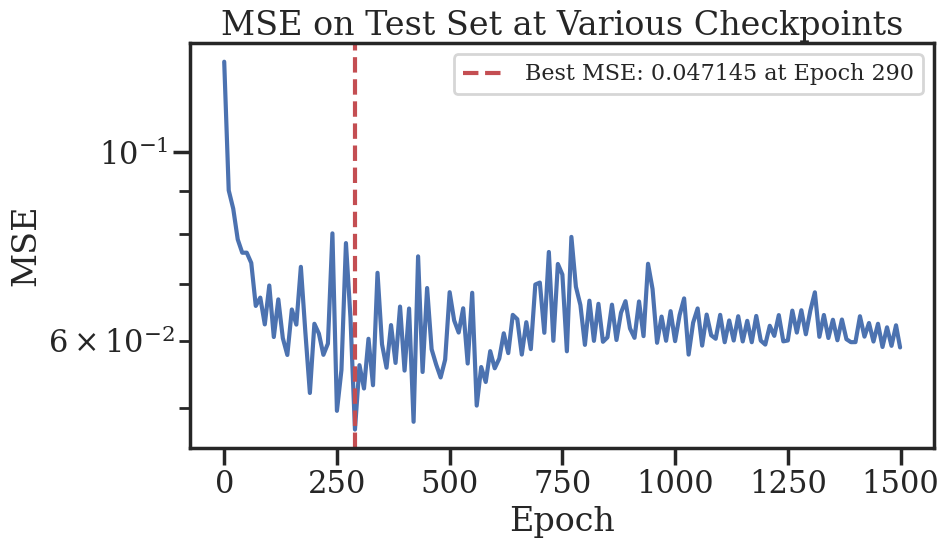

In [ ]:
# %% Evaluate the model on the test set

@eqx.filter_jit
def eval_step(model, X, times, key, inference_start=None):
    """ Evaluate the model on a batch of data. """
    X_recons = model(X, times, key, inference_start)
    return X_recons

def eval_on_test_set(model, key):
    mses = []
    new_key, _ = jax.random.split(key)
    for i, batch in enumerate(testloader):
        new_key, _ = jax.random.split(new_key)
        (X_true, times), X_labs_outs = batch

        X_recons = eval_step(model, X_true, times, new_key, inference_start=None)
        if use_nll_loss:
            X_recons = X_recons[:, :, :data_size]
        if dataset in repeat_datasets:
            mse = jnp.mean((X_recons - X_labs_outs)**2)
        else:
            mse = jnp.mean((X_recons - X_true)**2)
        mses.append(mse)

    return np.mean(mses), np.median(mses), np.min(mses)

test_key, _ = jax.random.split(train_key)
mean_mse, median_mse, min_mse = eval_on_test_set(model, test_key)

logger.info("Evaluation of MSE on the test set, at the end of the training (Current Best Model):")
logger.info(f"    - Mean : {mean_mse:.6f}")
logger.info(f"    - Median : {median_mse:.6f}")
logger.info(f"    - Min : {min_mse:.6f}")

nb_epochs = config['training']['nb_epochs']
checkpoint_every = config['training']['checkpoint_every']

best_model = model
best_mse = mean_mse
best_mse_epoch = nb_epochs-1        ## TODO: model might not have been trained for all epochs


if os.path.exists(artefacts_folder+"test_mses.npz"):
    checkpoints_data = np.load(artefacts_folder+"test_mses.npz")
    mses_chekpoints = checkpoints_data['data']
    best_mse_epoch = checkpoints_data['best_epoch'].item()
    best_mse = checkpoints_data['best_mse'].item()
    best_model = eqx.tree_deserialise_leaves(checkpoints_folder+f"model_{best_mse_epoch}.eqx", model)
    id_checkpoints = (np.arange(0, nb_epochs, checkpoint_every).tolist() + [nb_epochs-1])[:len(mses_chekpoints)]
    logger.info("Checkpoints MSE artefact file found. Loading it.")

else:
    mses_chekpoints = [] 
    id_checkpoints = []

    ## Lead the model at each checkpoint and evaluate it
    for i in list(range(0, nb_epochs, checkpoint_every))+[nb_epochs-1]:
        try:
            model = eqx.tree_deserialise_leaves(checkpoints_folder+f"model_{i}.eqx", model)
        except:
            logger.info(f"Checkpoint {i} not found. Skipping.")
            continue

        mean, med, min_ = eval_on_test_set(model, test_key)
        mses_chekpoints.append(mean)
        id_checkpoints.append(i)

        if mean<best_mse:
            best_model = model
            best_mse = mean
            best_mse_epoch = i
            logger.info(f"New best model found at epoch {i} with MSE: {best_mse:.6f}")
        # logger.info(f"Checkpoint {i} MSE: {mean:.6f} (Mean), {med:.6f} (Median), {min_:.6f} (Min)")

    ## Save the checkpoints MSEs artefacts
    np.savez(artefacts_folder+"test_mses.npz", data=np.array(mses_chekpoints), best_epoch=best_mse_epoch, best_mse=best_mse)

## Plot the MSE of the checkpoints
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = sbplot(id_checkpoints, mses_chekpoints, title="MSE on Test Set at Various Checkpoints", x_label='Epoch', y_label='MSE', ax=ax, y_scale="log", linewidth=3);
plt.axvline(x=best_mse_epoch, color='r', linestyle='--', linewidth=3, label=f"Best MSE: {best_mse:.6f} at Epoch {best_mse_epoch}")
plt.legend(fontsize=16)
plt.draw();
plt.savefig(plots_folder+"checkpoints_mse.png", dpi=100, bbox_inches='tight')
logger.info(f"Best model found at epoch {best_mse_epoch} with MSE: {best_mse:.6f}")


# ## Very importtant: Set the best model on test set as the model, for visualisation TODO
# model = best_model

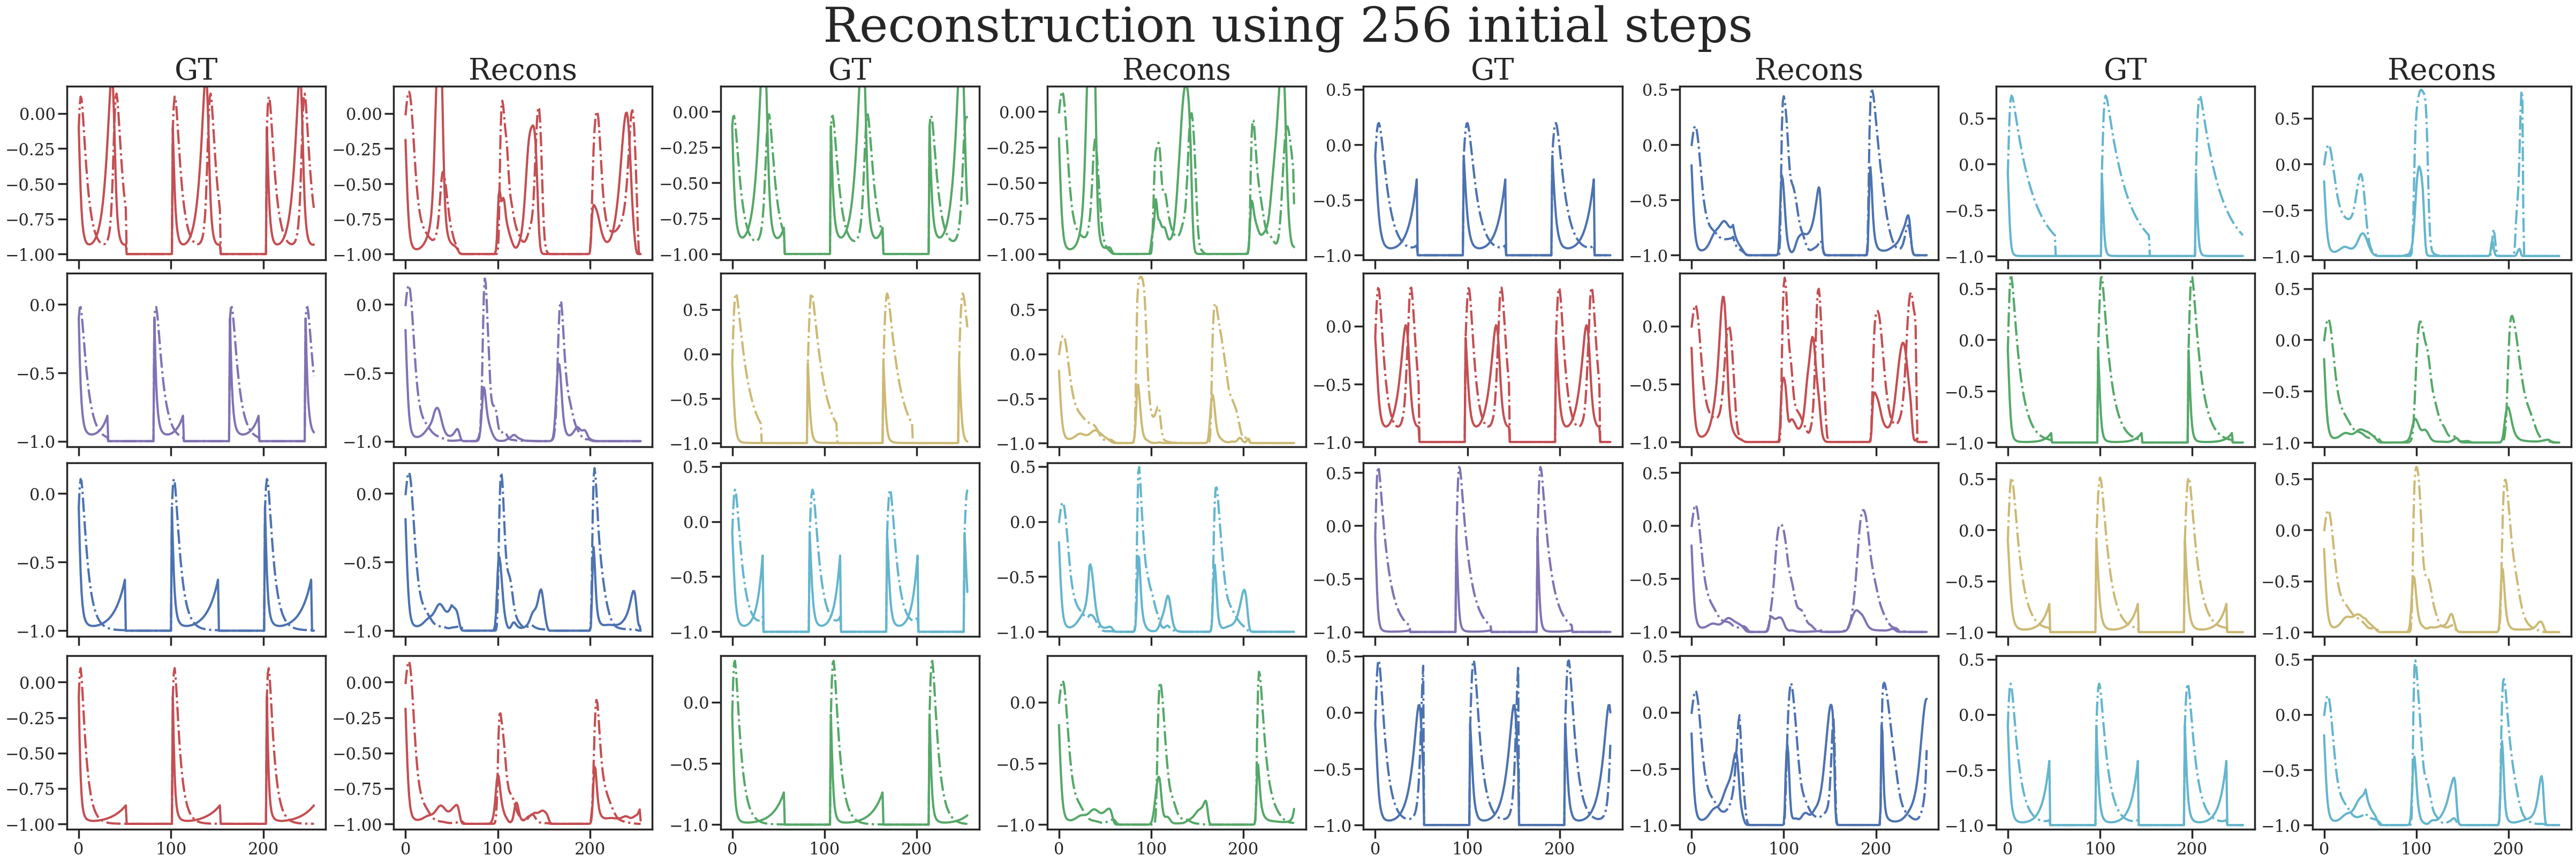

In [ ]:
# %% Visualising a few reconstruction samples

## Set inference mode to True
visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

nb_cols = 3 if use_nll_loss else 2
fig, axs = plt.subplots(4, 4*nb_cols, figsize=(16*3, 16), sharex=True, constrained_layout=True)

batch = next(iter(visloader))
(xs_true, times), labels = batch

inference_start = config['training']['inference_start']
xs_recons = eval_step(model=model, 
                      X=xs_true, 
                      times=times, 
                      key=test_key, 
                      inference_start=inference_start)

if use_nll_loss:
    xs_uncert = xs_recons[:, :, data_size:]
    xs_recons = xs_recons[:, :, :data_size]

res = (width, width, data_size)
mpl.rcParams['lines.linewidth'] = 3

for i in range(4):
    for j in range(4):
        x = xs_true[i*4+j]
        x_recons = xs_recons[i*4+j]
        x_full = labels[i*4+j]

        ## Min/max along dim0, for both x and x_recons
        min_0, max_0 = min(np.min(x[:, dim0]), np.min(x_recons[:, dim0])), max(np.max(x[:, dim0]), np.max(x_recons[:, dim0]))
        min_1, max_1 = min(np.min(x[:, dim1]), np.min(x_recons[:, dim1])), max(np.max(x[:, dim1]), np.max(x_recons[:, dim1]))
        eps = 0.04

        if dataset in image_datasets:
            to_plot = x.reshape(res)
            if dataset=="celeba":
                to_plot = (to_plot + 1) / 2
            axs[i, nb_cols*j].imshow(to_plot, cmap='gray')
        elif dataset == "trends":
            axs[i, nb_cols*j].plot(x, color=colors[labels[i*4+j]])
        elif dataset in repeat_datasets:
            axs[i, nb_cols*j].set_ylim([min_1-eps, max_1+eps])
            axs[i, nb_cols*j].plot(x_full[:, dim0], color=colors[(i*4+j)%len(colors)])
            axs[i, nb_cols*j].plot(x_full[:, dim1], color=colors[(i*4+j)%len(colors)], linestyle='-.')
        else:
            # axs[i, nb_cols*j].set_xlim([min_0-eps, max_0+eps])
            axs[i, nb_cols*j].set_ylim([min_1-eps, max_1+eps])
            axs[i, nb_cols*j].plot(x[:, dim0], color=colors[labels[i*4+j]%len(colors)])
            axs[i, nb_cols*j].plot(x[:, dim1], color=colors[labels[i*4+j]%len(colors)], linestyle='-.')
        if i==0:
            axs[i, nb_cols*j].set_title("GT", fontsize=40)
        # axs[i, nb_cols*j].axis('off')

        if dataset in image_datasets:
            to_plot = x_recons.reshape(res)
            if dataset=="celeba":
                to_plot = (to_plot + 1) / 2
            axs[i, nb_cols*j+1].imshow(to_plot, cmap='gray')
        elif dataset in dynamics_datasets and dataset not in repeat_datasets:
            # axs[i, nb_cols*j+1].set_xlim([min_0-eps, max_0+eps])
            axs[i, nb_cols*j+1].set_ylim([min_1-eps, max_1+eps])
            axs[i, nb_cols*j+1].plot(x_recons[:, dim0], color=colors[labels[i*4+j]%len(colors)])
            axs[i, nb_cols*j+1].plot(x_recons[:, dim1], color=colors[labels[i*4+j]%len(colors)], linestyle='-.')
        elif dataset in repeat_datasets:
            axs[i, nb_cols*j+1].set_ylim([min_1-eps, max_1+eps])
            axs[i, nb_cols*j+1].plot(x_recons[:, dim0], color=colors[(i*4+j)%len(colors)])
            axs[i, nb_cols*j+1].plot(x_recons[:, dim1], color=colors[(i*4+j)%len(colors)], linestyle='-.')
        else:
            axs[i, nb_cols*j+1].plot(x_recons, color=colors[labels[i*4+j]])
        if i==0:
            axs[i, nb_cols*j+1].set_title("Recons", fontsize=40)
        # axs[i, nb_cols*j+1].axis('off')

        if use_nll_loss:
            logger.info(f"Min/Max Uncertainty: {np.min(xs_uncert):.3f}, {np.max(xs_uncert):.3f}")
            if dataset in image_datasets:
                to_plot = xs_uncert[i*4+j].reshape(res)
                axs[i, nb_cols*j+2].imshow(to_plot, cmap='gray')
            elif dataset in dynamics_datasets:
                to_plot = xs_uncert[i*4+j]
                axs[i, nb_cols*j+2].plot(to_plot[:, dim0], to_plot[:, dim1], color=colors[labels[i*4+j]%len(colors)])

            if i==0:
                axs[i, nb_cols*j+2].set_title("Uncertainty", fontsize=36)
            # axs[i, nb_cols*j+2].axis('off')

plt.suptitle(f"Reconstruction using {inference_start} initial steps", fontsize=65)
plt.draw();
plt.savefig(plots_folder+"samples_generated.png", dpi=100, bbox_inches='tight')